# Color Transfer by using Wasserstein-2 Generative Networks
DenseICNNs for fitting cycle monotone color palette transfer.
**GPU-only implementation.**

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import os, sys
sys.path.append("..")

import torch
torch.random.manual_seed(0xBADBEEF)

from src.icnn import DenseICNN
from src.tools import compute_l1_norm, plot_rgb_cloud
from src import distributions

from PIL import Image

### Config

In [2]:
INPUT = '../data/color_transfer/forest_road.jpg'
OUTPUT = '../data/color_transfer/country_house.jpg'
L1 = 1e-10
LAMBDA = 3.
GPU_DEVICE = 0
BATCH_SIZE = 1024
LR = 1e-3

In [3]:
assert torch.cuda.is_available()
torch.cuda.set_device(GPU_DEVICE)

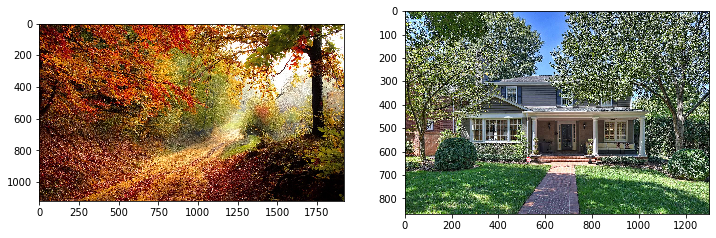

In [4]:
im_X = Image.open(INPUT).convert('RGB')
im_Y = Image.open(OUTPUT).convert('RGB')

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
axes[0].imshow(im_X)
axes[1].imshow(im_Y)

In [5]:
X_sampler = distributions.TensorDatasetSampler(
    (np.asarray(im_X).transpose(2, 0, 1).reshape(3, -1) / 255.).T,
    requires_grad=True
)
Y_sampler = distributions.TensorDatasetSampler(
    (np.asarray(im_Y).transpose(2, 0, 1).reshape(3, -1) / 255.).T,
    requires_grad=True
)
    
torch.cuda.empty_cache()

## Discriminators Setup

In [6]:
D = DenseICNN(
    3, rank=3, hidden_layer_sizes=[128, 128, 64],
    dropout=1e-5, strong_convexity=1e-6,
).cuda()

print(np.sum([np.prod(list(p.shape)) for p in D.parameters()]), 'parameters in Discriminative Network')

for p in D.parameters():
    p.data = torch.randn(p.shape, device='cuda', dtype=torch.float32) / 2.
    
D_conj = DenseICNN(
    3, rank=3,
    hidden_layer_sizes=[128, 128, 64],
    dropout=1e-5, strong_convexity=1e-6,
).cuda()

28800 parameters in Discriminative Network


Discriminator pretraining to satisfy $\nabla\psi_{\theta}(x)\approx x$.

In [7]:
pre_D_opt = torch.optim.Adam(D.parameters(), lr=1e-3, betas=(0.8, 0.9))
BLOW = 2.

D.train(True)
loss = np.inf

for iteration in tqdm(range(10000)):
    X = ((torch.rand((BATCH_SIZE, 3), dtype=torch.float32, device='cuda') -.5) * BLOW + .5).detach()
    X.requires_grad_(True)

    loss = ((D.push(X) - X) ** 2).sum(dim=1).mean() + L1 * compute_l1_norm(D)
    loss.backward()
    pre_D_opt.step()
    pre_D_opt.zero_grad()
    D.convexify()
    
    if iteration % 500 == 0:
        clear_output(wait=True)
        print('Pretraining the discriminator for D.push(x)=x')
        print('Current loss:', loss.item())
    
    if loss.item() < 1e-3:
        clear_output(wait=True)
        break
print('Final Loss:', loss.item())
D_conj.load_state_dict(D.state_dict())

  9%|▉         | 928/10000 [00:09<01:33, 97.05it/s] 

Final Loss: 0.0009214782039634883


<All keys matched successfully>

### Main training

In [8]:
D_opt = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.8, 0.99))
D_conj_opt = torch.optim.Adam(D_conj.parameters(), lr=LR, betas=(0.4, 0.4))

Iteration 5000
Plotting takes time!


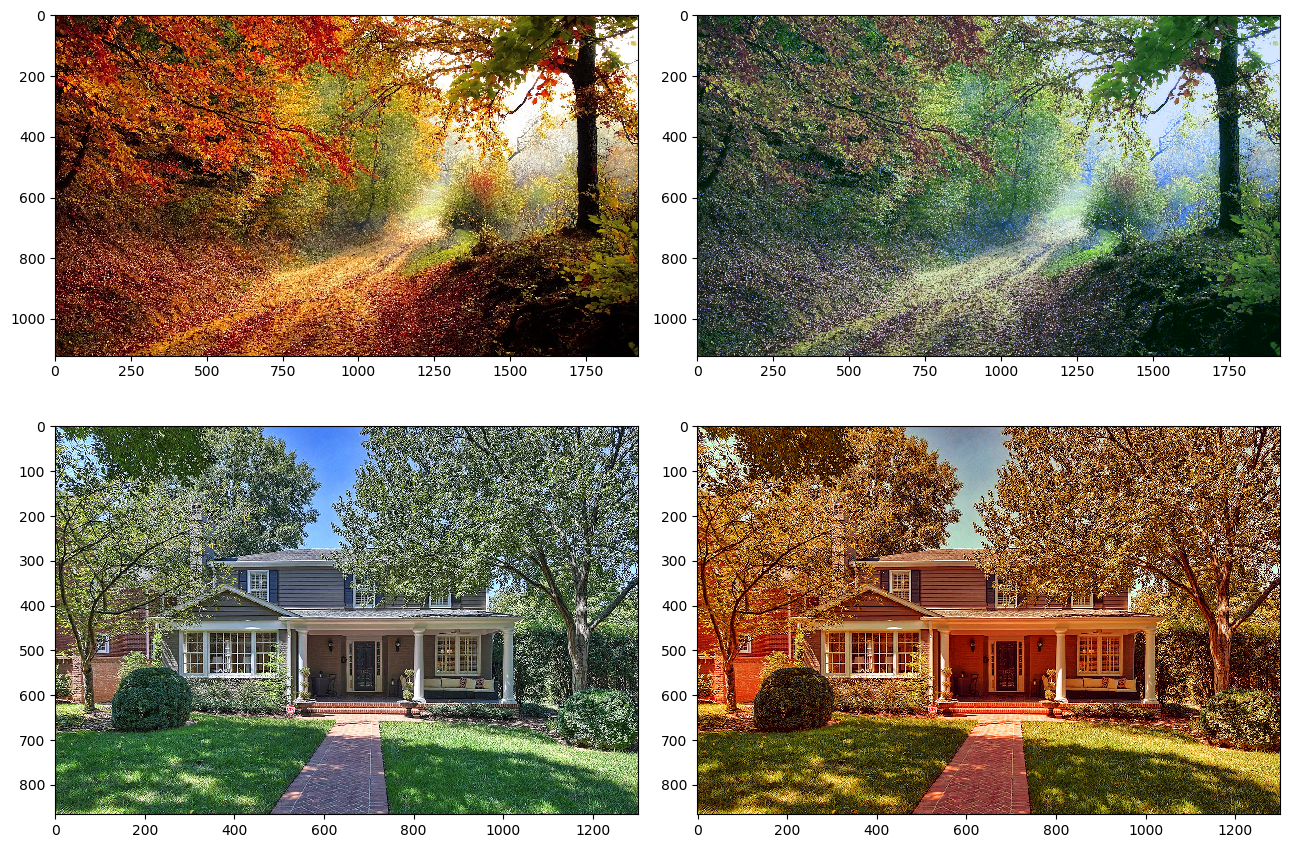

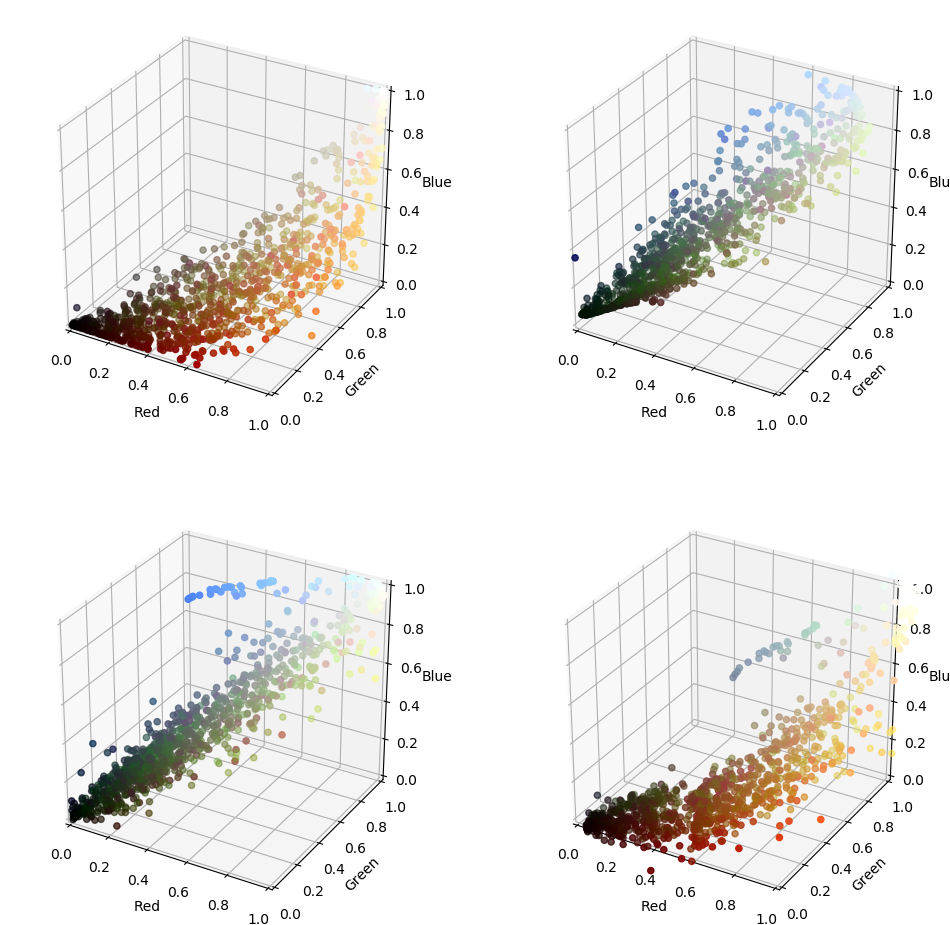

In [9]:
print('Fitting the monotone generative mapping')
for iteration in range(5001):
    D.train(True); D_conj.train(True)
    
    X = X_sampler.sample(BATCH_SIZE)
    Y = Y_sampler.sample(BATCH_SIZE)

    # Negative Wasserstein distance
    Y_inv = D_conj.push(Y).detach()
    D_opt.zero_grad()
    D_conj_opt.zero_grad()    
    W_loss = (D(X) - D(Y_inv)).mean()
    # Non-backpropagated part
    with torch.no_grad():
        W_loss_nograd = (- (X ** 2).sum(dim=1) / 2).mean() +\
        ((Y_inv * Y).sum(dim=1) - (Y_inv ** 2).sum(dim=1) / 2 ).mean()
    
    # Weight L1 regularization
    D_reg = compute_l1_norm(D)
    D_conj_reg = compute_l1_norm(D_conj)
    W_loss += L1 * (D_reg + D_conj_reg)
    
    # Cycle Regularization
    cycle_loss = ((D.push(D_conj.push(Y)) - Y.detach()) ** 2).mean()
    W_loss += LAMBDA * cycle_loss

    W_loss.backward()
    D_opt.step(); D_conj_opt.step()
    D_opt.zero_grad(); D_conj_opt.zero_grad()
    D.convexify(); D_conj.convexify()        
            
    if iteration % 1000 == 0:
        clear_output(wait=True)
        print("Iteration", iteration)
        print("Plotting takes time!")
        D.train(False); D_conj.train(False)
        
        fig = plt.figure(figsize=(13, 9), dpi=100)
        fig.add_subplot(221)
        plt.imshow(im_X)

        fig.add_subplot(222)
        X = (np.asarray(im_X).transpose(2, 0, 1).reshape(3, -1) / 255.).T
        X_pushed = np.zeros_like(X)
        pos = 0; batch = 4999
        while pos < len(X):
            X_pushed[pos:pos+batch] = D.push(
                torch.tensor(X[pos:pos+batch], device='cuda', requires_grad=True).float()
            ).detach().cpu().numpy()
            pos += batch

        im_X_pushed = (
            np.clip(
                (X_pushed.T.reshape(
                    np.asarray(im_X).transpose(2, 0, 1).shape
                )).transpose(1, 2, 0), 0, 1) * 255
        ).astype(int)
        plt.imshow(im_X_pushed)
        
        fig.add_subplot(223)
        plt.imshow(im_Y)

        fig.add_subplot(224)
        Y = (np.asarray(im_Y).transpose(2, 0, 1).reshape(3, -1) / 255.).T
        Y_pushed = np.zeros_like(Y)
        pos = 0; batch = 4999
        while pos < len(Y):
            Y_pushed[pos:pos+batch] = D_conj.push(
                torch.tensor(Y[pos:pos+batch], device='cuda', requires_grad=True).float()
            ).detach().cpu().numpy()
            pos += batch
        
        im_Y_pushed = (
            np.clip(
                (Y_pushed.T.reshape(
                    np.asarray(im_Y).transpose(2, 0, 1).shape
                )).transpose(1, 2, 0), 0, 1) * 255
        ).astype(int)
        plt.imshow(im_Y_pushed)
        fig.tight_layout()
    
        fig = plt.figure(figsize=(12, 12), dpi=100)
        ax = fig.add_subplot(221, projection='3d')
        X = X_sampler.sample(1024)
        plot_rgb_cloud(X.cpu().detach().numpy(), ax)
        ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_zlim(0, 1)
        
        ax = fig.add_subplot(222, projection='3d')
        X_pushed = D.push(
            torch.tensor(X, device='cuda', dtype=torch.float32, requires_grad=True)
        )
        plot_rgb_cloud(X_pushed.cpu().detach().numpy(), ax)
        ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_zlim(0, 1)
        
        ax = fig.add_subplot(223, projection='3d')
        Y = Y_sampler.sample(1024)
        plot_rgb_cloud(Y.cpu().detach().numpy(), ax)
        ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_zlim(0, 1)
        
        ax = fig.add_subplot(224, projection='3d')
        Y_pushed = D_conj.push(
            torch.tensor(Y, device='cuda', dtype=torch.float32, requires_grad=True)
        )
        plot_rgb_cloud(Y_pushed.cpu().detach().numpy(), ax)
        ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_zlim(0, 1)
        plt.grid()
        
        plt.show()

        fig.tight_layout()